In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import json
import pickle
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score
from scikeras.wrappers import KerasRegressor
from keras.wrappers.scikit_learn import KerasClassifier
from bayes_opt import BayesianOptimization  
from Data_mining import data_mining

In [2]:
#Data mining process
#df=data_mining("ETH-USDT", "5m", "2020/04/09", "2023/08/11")
#df.to_csv("ETH-USDT_5m.csv")
#df

In [3]:
df=pd.read_csv('./ETH-USDT_5m.csv')
df=df.set_index(['time'])
df

,open,close,high,low,volume
time,,,,,
2020-04-09 00:00:00,172.20,172.12,172.34,172.07,204.24
2020-04-09 00:05:00,172.14,171.93,172.16,171.80,191.04
2020-04-09 00:10:00,171.94,172.12,172.26,171.91,200.84
2020-04-09 00:15:00,172.12,172.02,172.28,171.98,198.00
2020-04-09 00:20:00,171.99,171.87,172.10,171.72,208.17
...,...,...,...,...,...
2023-08-10 23:35:00,1849.86,1850.13,1850.13,1849.32,585.88
2023-08-10 23:40:00,1850.14,1850.67,1850.71,1850.00,443.23
2023-08-10 23:45:00,1850.67,1851.03,1851.54,1850.67,1229.89


In [4]:
pd.date_range(start='2021-01-01 00:00:00', end='2023-08-03 23:55:00').difference(df.index)

DatetimeIndex([], dtype='datetime64[ns]', freq=None)

In [5]:
df['tomorrow']=df['close'].shift(-1)
df['target']=(df['tomorrow'] > df['close']).astype(int)
df

,open,close,high,low,volume,tomorrow,target
time,,,,,,,
2020-04-09 00:00:00,172.20,172.12,172.34,172.07,204.24,171.93,0
2020-04-09 00:05:00,172.14,171.93,172.16,171.80,191.04,172.12,1
2020-04-09 00:10:00,171.94,172.12,172.26,171.91,200.84,172.02,0
2020-04-09 00:15:00,172.12,172.02,172.28,171.98,198.00,171.87,0
2020-04-09 00:20:00,171.99,171.87,172.10,171.72,208.17,171.88,1
...,...,...,...,...,...,...,...
2023-08-10 23:35:00,1849.86,1850.13,1850.13,1849.32,585.88,1850.67,1
2023-08-10 23:40:00,1850.14,1850.67,1850.71,1850.00,443.23,1851.03,1
2023-08-10 23:45:00,1850.67,1851.03,1851.54,1850.67,1229.89,1850.37,0


In [6]:
df=df.drop(df.index[-1])
del df['tomorrow']

In [7]:
df

,open,close,high,low,volume,target
time,,,,,,
2020-04-09 00:00:00,172.20,172.12,172.34,172.07,204.24,0
2020-04-09 00:05:00,172.14,171.93,172.16,171.80,191.04,1
2020-04-09 00:10:00,171.94,172.12,172.26,171.91,200.84,0
2020-04-09 00:15:00,172.12,172.02,172.28,171.98,198.00,0
2020-04-09 00:20:00,171.99,171.87,172.10,171.72,208.17,1
...,...,...,...,...,...,...
2023-08-10 23:30:00,1849.37,1849.86,1849.86,1849.32,666.97,1
2023-08-10 23:35:00,1849.86,1850.13,1850.13,1849.32,585.88,1
2023-08-10 23:40:00,1850.14,1850.67,1850.71,1850.00,443.23,1


In [8]:
horizons=[12, 60, 120, 216, 288]
new_predictors=[]

for horizon in horizons:
    rolling_averages=df.rolling(horizon).mean()
    ratio_column=f"Close_Ratio_{horizon}"
    df[ratio_column]=df['close']/rolling_averages['close']
    
    trend_column=f"Trend_{horizon}"
    df[trend_column]=df.shift(1).rolling(horizon).sum()['target']
    
    new_predictors+=[ratio_column, trend_column]

In [9]:
df=df.dropna()
df

,open,close,high,low,volume,target,Close_Ratio_12,Trend_12,Close_Ratio_60,Trend_60,Close_Ratio_120,Trend_120,Close_Ratio_216,Trend_216,Close_Ratio_288,Trend_288
time,,,,,,,,,,,,,,,,
2020-04-10 00:00:00,169.03,168.94,169.04,168.86,190.78,1,0.999995,5.0,0.996742,27.0,0.994254,55.0,0.991846,106.0,0.989144,144.0
2020-04-10 00:05:00,168.94,169.06,169.16,168.94,212.42,1,1.000493,6.0,0.997531,27.0,0.995063,55.0,0.992593,107.0,0.989904,145.0
2020-04-10 00:10:00,169.03,169.64,169.68,169.00,183.46,1,1.003609,6.0,1.000937,28.0,0.998548,56.0,0.996041,107.0,0.993350,145.0
2020-04-10 00:15:00,169.66,169.69,169.69,169.43,199.67,1,1.003479,7.0,1.001224,28.0,0.998913,56.0,0.996384,107.0,0.993690,146.0
2020-04-10 00:20:00,169.68,170.48,170.48,169.57,190.82,0,1.007515,7.0,1.005791,29.0,1.003589,57.0,1.001046,108.0,0.998344,147.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-10 23:30:00,1849.37,1849.86,1849.86,1849.32,666.97,1,1.000355,6.0,0.999631,28.0,0.998612,55.0,0.998719,96.0,0.998440,136.0
2023-08-10 23:35:00,1849.86,1850.13,1850.13,1849.32,585.88,1,1.000496,6.0,0.999792,29.0,0.998763,56.0,0.998877,96.0,0.998586,136.0
2023-08-10 23:40:00,1850.14,1850.67,1850.71,1850.00,443.23,1,1.000758,7.0,1.000107,29.0,0.999057,57.0,0.999183,96.0,0.998878,136.0


In [10]:
dataset=df.iloc[:, 0:df.shape[1]].values
dataset.shape

(351058, 16)

In [11]:
scaler=preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset_scaled=scaler.fit_transform(dataset)

In [12]:
dataset_scaled.shape

(351058, 16)

In [13]:
dataset_scaled[:, 5]

array([1., 1., 1., ..., 1., 0., 1.])

In [14]:
training_set, test_and_validation_set=model_selection.train_test_split(dataset_scaled, test_size=0.01, shuffle=False)
training_set.shape

(347547, 16)

In [15]:
test_and_validation_set.shape

(3511, 16)

In [16]:
validation_set, test_set=model_selection.train_test_split(test_and_validation_set, test_size=0.5, shuffle=False)
print(validation_set.shape)
print(test_set.shape)

(1755, 16)
(1756, 16)


In [17]:
X_train=[]
y_train=[]
for i in range(12, len(training_set)):
    X_train.append(training_set[i-12:i, :])
    y_train.append(training_set[i, 5])
X_train, y_train=np.array(X_train), np.array(y_train)

In [18]:
X_train=np.reshape(X_train, newshape=(X_train.shape[0], X_train.shape[1], df.shape[1]))
X_train.shape

(347535, 12, 16)

In [19]:
y_train.shape

(347535,)

In [20]:
X_validation=[]
y_validation=[]
for i in range(12, len(validation_set)):
    X_validation.append(validation_set[i-12:i, :])
    y_validation.append(validation_set[i, 5])
X_validation, y_validation=np.array(X_validation), np.array(y_validation)
X_validation=np.reshape(X_validation, newshape=(X_validation.shape[0], X_validation.shape[1], df.shape[1]))
X_validation.shape

(1743, 12, 16)

In [21]:
y_validation.shape

(1743,)

In [22]:
test_inputs=test_and_validation_set[len(test_and_validation_set)-len(test_set):]

In [23]:
X_test=[]
y_test=[]
for i in range(12, len(test_inputs)):
    X_test.append(test_inputs[i-12:i, :])
    y_test.append(test_inputs[i, 5])
X_test, y_test=np.array(X_test), np.array(y_test)
X_test=np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1], df.shape[1]))
X_test.shape

(1744, 12, 16)

### LSTM Regression Model

In [46]:
lstm_reg_model=tf.keras.models.load_model('./LSTM Model/LSTM Regression/LSTM_model.h5')

In [47]:
df_reg=pd.read_csv('./ETH-USDT_5m.csv')
df_reg=df_reg.set_index(['time'])

In [48]:
dataset_reg=df_reg.iloc[:, 0:df_reg.shape[1]].values


scaler_reg=preprocessing.MinMaxScaler(feature_range=(0, 1))
dataset_reg_scaled=scaler_reg.fit_transform(dataset_reg)

training_set_reg, test_and_validation_set_reg=model_selection.train_test_split(dataset_reg_scaled, test_size=0.01, shuffle=False)
validation_set_reg, test_set_reg=model_selection.train_test_split(test_and_validation_set_reg, test_size=0.5, shuffle=False)

In [49]:
X_train_reg=[]
y_train_reg=[]
for i in range(12, len(training_set)):
    X_train_reg.append(training_set_reg[i-12:i, :])
    y_train_reg.append(training_set_reg[i, 1])
X_train_reg, y_train_reg=np.array(X_train_reg), np.array(y_train_reg)

In [50]:
X_validation_reg=[]
y_validation_reg=[]
for i in range(12, len(validation_set_reg)):
    X_validation_reg.append(validation_set_reg[i-12:i, :])
    y_validation_reg.append(validation_set_reg[i, 1])
X_validation_reg, y_validation_reg=np.array(X_validation_reg), np.array(y_validation_reg)
X_validation_reg=np.reshape(X_validation_reg, newshape=(X_validation_reg.shape[0], X_validation_reg.shape[1], df_reg.shape[1]))
X_validation_reg.shape

(1745, 12, 5)

In [51]:
test_inputs_reg=test_and_validation_set_reg[len(test_and_validation_set_reg)-len(test_set_reg):]

In [52]:
X_test_reg=[]
y_test_reg=[]
for i in range(12, len(test_inputs_reg)):
    X_test_reg.append(test_inputs_reg[i-12:i, :])
    y_test_reg.append(test_inputs_reg[i, 1])
X_test_reg, y_test_reg=np.array(X_test_reg), np.array(y_test_reg)
X_test_reg=np.reshape(X_test_reg, newshape=(X_test_reg.shape[0], X_test_reg.shape[1], df_reg.shape[1]))
X_test_reg.shape

(1745, 12, 5)

In [53]:
score_reg=lstm_reg_model.evaluate(X_test_reg, y_test_reg)

55/55 [==============================] - 2s 13ms/step - loss: 5.8535e-06


In [54]:
predicted_close_prices=lstm_reg_model.predict(X_test_reg)

55/55 [==============================] - 2s 9ms/step


In [55]:
predicted_close_prices.shape

(1745, 1)

In [56]:
prediction_copies_array = np.repeat(predicted_close_prices,5, axis=-1)
predicted_close_prices = scaler_reg.inverse_transform(np.reshape(prediction_copies_array,(len(predicted_close_prices),5)))[:,0]

In [57]:
y_test_reg_copy = np.repeat(y_test_reg,5, axis=-1)
y_test_reg = scaler_reg.inverse_transform(np.reshape(y_test_reg_copy,(len(y_test_reg),5)))[:,0]

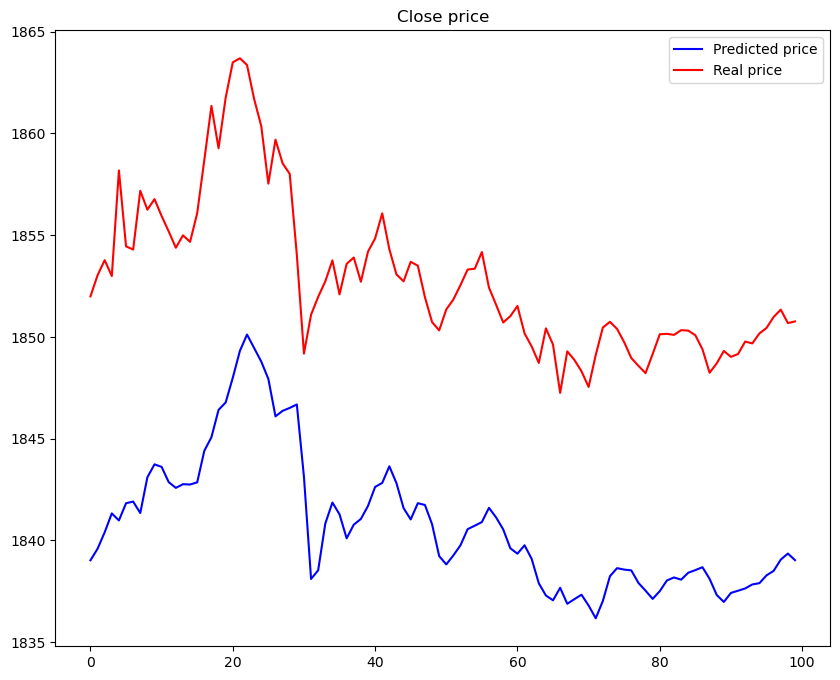

In [58]:
plt.figure(figsize=(10,8))
plt.plot(predicted_close_prices[len(predicted_close_prices)-100:len(predicted_close_prices)], color='blue', label='Predicted price')
plt.plot(y_test_reg[len(y_test_reg)-100:len(y_test_reg)], color='red', label='Real price')
plt.title("Close price")
plt.legend()
plt.show()

In [88]:
test_data_reg={'Real close prices':y_test_reg, 'Predicted close prices':predicted_close_prices}

In [89]:
df_reg.index[-1745:].values

array(['2023-08-04 22:35:00', '2023-08-04 22:40:00',
       '2023-08-04 22:45:00', ..., '2023-08-10 23:45:00',
       '2023-08-10 23:50:00', '2023-08-10 23:55:00'], dtype=object)

In [90]:
test_df_reg=pd.DataFrame(test_data_reg, index=df_reg.index[-1745:].values)

In [91]:
test_df_reg

,Real close prices,Predicted close prices
2023-08-04 22:35:00,1830.700303,1821.652954
2023-08-04 22:40:00,1832.450626,1820.610229
2023-08-04 22:45:00,1833.920898,1821.169434
2023-08-04 22:50:00,1833.050737,1822.466919
2023-08-04 22:55:00,1831.480447,1822.711670
...,...,...
2023-08-10 23:35:00,1850.443948,1838.286011
2023-08-10 23:40:00,1850.984047,1838.507080
2023-08-10 23:45:00,1851.344114,1839.059570
2023-08-10 23:50:00,1850.683992,1839.357178


In [92]:
test_df_reg['Predicted tomorrow']=test_df_reg['Predicted close prices'].shift(-1)
test_df_reg['Real tomorrow']=test_df_reg['Real close prices'].shift(-1)
test_df_reg

,Real close prices,Predicted close prices,Predicted tomorrow,Real tomorrow
2023-08-04 22:35:00,1830.700303,1821.652954,1820.610229,1832.450626
2023-08-04 22:40:00,1832.450626,1820.610229,1821.169434,1833.920898
2023-08-04 22:45:00,1833.920898,1821.169434,1822.466919,1833.050737
2023-08-04 22:50:00,1833.050737,1822.466919,1822.711670,1831.480447
2023-08-04 22:55:00,1831.480447,1822.711670,1821.638916,1832.230586
...,...,...,...,...
2023-08-10 23:35:00,1850.443948,1838.286011,1838.507080,1850.984047
2023-08-10 23:40:00,1850.984047,1838.507080,1839.059570,1851.344114
2023-08-10 23:45:00,1851.344114,1839.059570,1839.357178,1850.683992
2023-08-10 23:50:00,1850.683992,1839.357178,1839.033691,1850.764007


In [93]:
test_df_reg['Predicted target']=(test_df_reg['Predicted tomorrow']>test_df_reg['Predicted close prices']).astype(int)
test_df_reg['Real target']=(test_df_reg['Real tomorrow']>test_df_reg['Real close prices']).astype(int)

In [94]:
test_df_reg

,Real close prices,Predicted close prices,Predicted tomorrow,Real tomorrow,Predicted target,Real target
2023-08-04 22:35:00,1830.700303,1821.652954,1820.610229,1832.450626,0,1
2023-08-04 22:40:00,1832.450626,1820.610229,1821.169434,1833.920898,1,1
2023-08-04 22:45:00,1833.920898,1821.169434,1822.466919,1833.050737,1,0
2023-08-04 22:50:00,1833.050737,1822.466919,1822.711670,1831.480447,1,0
2023-08-04 22:55:00,1831.480447,1822.711670,1821.638916,1832.230586,0,1
...,...,...,...,...,...,...
2023-08-10 23:35:00,1850.443948,1838.286011,1838.507080,1850.984047,1,1
2023-08-10 23:40:00,1850.984047,1838.507080,1839.059570,1851.344114,1,1
2023-08-10 23:45:00,1851.344114,1839.059570,1839.357178,1850.683992,1,0
2023-08-10 23:50:00,1850.683992,1839.357178,1839.033691,1850.764007,0,1


In [98]:
precision_score(test_df_reg['Real target'].values, test_df_reg['Predicted target'])

0.5164835164835165

### LSTM Classification Model

In [31]:
#def create_lstm_model(neurons, dropout_rate):
    #model=tf.keras.Sequential()
    #model.add(tf.keras.layers.LSTM(units=neurons, return_sequences=True, input_shape=(X_validation.shape[1], X_validation.shape[2])))
    #model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    #model.add(tf.keras.layers.LSTM(units=neurons, return_sequences=True))
    #model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    #model.add(tf.keras.layers.LSTM(units=neurons, return_sequences=True))
    #model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    #model.add(tf.keras.layers.LSTM(units=neurons, return_sequences=True))
    #model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    #model.add(tf.keras.layers.LSTM(units=neurons, return_sequences=True))
    #model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    #model.add(tf.keras.layers.LSTM(units=neurons, return_sequences=False))
    #model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    #model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
    
    #return model

#neurons=[40,50,60]
#dropout_rate=[0.2, 0.3, 0.4, 0.5]
#epochs=[80,100]
#batch_size=[16,24,32]
#param_grid=dict(model__neurons=neurons, model__dropout_rate=dropout_rate, epochs=epochs, batch_size=batch_size)
#tuning_model=KerasClassifier(model=create_lstm_model, loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'], verbose=0)
#grid=model_selection.GridSearchCV(estimator=tuning_model, param_grid=param_grid, n_jobs=None, cv=3, verbose=0)
#grid_result=grid.fit(X_validation, y_validation)

In [32]:
#grid_result.best_params_

In [33]:
#grid_result.best_score_

In [34]:
#grid_results_lstm_classification=grid_result.best_params_
#grid_results_lstm_classification['best_score']=grid_result.best_score_

In [35]:
#grid_results_lstm_classification

In [36]:
#with open('./LSTM Model/LSTM Classification/GridSearch_Results_LSTM_Classification.txt', 'w') as text_file:
    #text_file.write(json.dumps(grid_results_lstm_classification))

In [37]:
with open('./LSTM Model/LSTM Classification/GridSearch_Results_LSTM_Classification.txt') as text_file:
    grid_result=text_file.read()

grid_results_lstm_classification=json.loads(grid_result)
grid_results_lstm_classification

{'batch_size': 16,
 'epochs': 80,
 'model__dropout_rate': 0.2,
 'model__neurons': 60,
 'best_score': 0.5198529626280013}

In [38]:
#def create_lstm_model_bayesian(l1_1, l1_2, l2_1, l2_2, l2_4 ,l2_3, l2_5, l2_6, dropout_rate):
    #model=tf.keras.Sequential()
    #model.add(tf.keras.layers.LSTM(units=128, return_sequences=True, kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_1, l2=l2_1), bias_regularizer=tf.keras.regularizers.L2(l2_2), activity_regularizer=tf.keras.regularizers.L2(l2_3), input_shape=(X_validation.shape[1], X_validation.shape[2])))
    #model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
    #model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    #model.add(tf.keras.layers.LSTM(units=128, return_sequences=False))
    #model.add(tf.keras.layers.Dropout(rate=dropout_rate))
    #model.add(tf.keras.layers.Dense(units=1, activation='sigmoid', kernel_regularizer=tf.keras.regularizers.L1L2(l1=l1_2, l2=l2_4), bias_regularizer=tf.keras.regularizers.L2(l2_5), activity_regularizer=tf.keras.regularizers.L2(l2_6)))
    
    #model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    
    #return model

#pbounds={'l1_1':(0, 0.1), 'l1_2':(0, 0.1), 'l2_1':(0, 0.1), 'l2_2':(0, 0.1), 'l2_3':(0, 0.1), 'l2_4':(0, 0.1), 'l2_5':(0, 0.1), 'l2_6':(0, 0.1), 'dropout_rate':(0.4, 0.6)}
#model=KerasClassifier(build_fn=create_lstm_model_bayesian, epochs=100, batch_size=32)
#def optimize_lstm(l1_1, l1_2, l2_1, l2_2, l2_3, l2_4, l2_5, l2_6, dropout_rate):  
    #model.set_params(l1_1=float(l1_1), l1_2=float(l1_2), l2_1=float(l2_1), l2_2=float(l2_2), l2_3=float(l2_3), l2_4=float(l2_4), l2_5=float(l2_5), l2_6=float(l2_6), dropout_rate=float(dropout_rate))  
    #return -np.mean(sklearn.model_selection.cross_val_score(model, X_validation, y_validation, cv=3, n_jobs=None, scoring='accuracy')) 
#optimizer = BayesianOptimization(f=optimize_lstm, pbounds=pbounds, random_state=42)  
#optimizer.maximize(n_iter=20)

In [39]:
#optimizer.max['params']

In [40]:
#with open('./LSTM Model/LSTM Classification/BayesianSearch_Results_LSTM_Classification.txt', 'w') as text_file_bayes:
    #text_file_bayes.write(json.dumps(optimizer.max['params']))

In [41]:
with open('./LSTM Model/LSTM Classification/BayesianSearch_Results_LSTM_Classification.txt') as text_file:
    bayes_result=text_file.read()

bayes_results_lstm_classification=json.loads(bayes_result)
bayes_results_lstm_classification

{'dropout_rate': 0.4749080237694725,
 'l1_1': 0.09507143064099162,
 'l1_2': 0.0731993941811405,
 'l2_1': 0.05986584841970366,
 'l2_2': 0.015601864044243652,
 'l2_3': 0.015599452033620266,
 'l2_4': 0.005808361216819946,
 'l2_5': 0.08661761457749352,
 'l2_6': 0.06011150117432088}

In [22]:
lstm_model=tf.keras.Sequential()
lstm_model.add(tf.keras.layers.LSTM(units=128, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
lstm_model.add(tf.keras.layers.Dropout(rate=0.45))
lstm_model.add(tf.keras.layers.LSTM(units=128, return_sequences=True))
lstm_model.add(tf.keras.layers.Dropout(rate=0.45))
lstm_model.add(tf.keras.layers.LSTM(units=128, return_sequences=False))
lstm_model.add(tf.keras.layers.Dropout(rate=0.45))
lstm_model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

lstm_model.compile(loss='binary_crossentropy', optimizer='Adam', metrics=['accuracy'])

In [23]:
lstm_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 12, 128)           74240     
                                                                 
 dropout (Dropout)           (None, 12, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 12, 128)           131584    
                                                                 
 dropout_1 (Dropout)         (None, 12, 128)           0         
                                                                 
 lstm_2 (LSTM)               (None, 128)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense (Dense)               (None, 1)                 1

In [26]:
training_history=lstm_model.fit(X_train, y_train, epochs=100, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/100
10861/10861 [==============================] - 121s 11ms/step - loss: 0.6928 - accuracy: 0.5120 - val_loss: 0.6929 - val_accuracy: 0.5100
Epoch 2/100
10861/10861 [==============================] - 118s 11ms/step - loss: 0.6922 - accuracy: 0.5183 - val_loss: 0.6936 - val_accuracy: 0.5020
Epoch 3/100
10861/10861 [==============================] - 118s 11ms/step - loss: 0.6920 - accuracy: 0.5197 - val_loss: 0.6940 - val_accuracy: 0.5049
Epoch 4/100
10861/10861 [==============================] - 118s 11ms/step - loss: 0.6920 - accuracy: 0.5190 - val_loss: 0.6934 - val_accuracy: 0.5055
Epoch 5/100
10861/10861 [==============================] - 118s 11ms/step - loss: 0.6919 - accuracy: 0.5201 - val_loss: 0.6936 - val_accuracy: 0.5026
Epoch 6/100
10861/10861 [==============================] - 123s 11ms/step - loss: 0.6919 - accuracy: 0.5208 - val_loss: 0.6945 - val_accuracy: 0.5152
Epoch 7/100
10861/10861 [==============================] - 123s 11ms/step - loss: 0.6919 - accuracy:

In [44]:
training_loss_values_lstm_classification=training_history.history['loss']
training_accuracy_values_lstm_classification=training_history.history['accuracy']
validation_loss_values_lstm_classification=training_history.history['val_loss']
validation_accuracy_values_lstm_classification=training_history.history['val_accuracy']

In [45]:
lstm_model.save('./LSTM Model/LSTM Classification/LSTM_Classification_model.h5')
lstm_model.save_weights('./LSTM Model/LSTM Classification/LSTM Classification_model_weights')
np.savetxt('./LSTM Model/LSTM Classification/TrainingLossValues.txt', training_loss_values_lstm_classification)
np.savetxt('./LSTM Model/LSTM Classification/TrainingAccuracyValues.txt', training_accuracy_values_lstm_classification)
np.savetxt('./LSTM Model/LSTM Classification/ValidationLossValues.txt', validation_loss_values_lstm_classification)
np.savetxt('./LSTM Model/LSTM Classification/ValidationAccuracyValues.txt', validation_accuracy_values_lstm_classification)

In [99]:
lstm_model_classification=tf.keras.models.load_model('./LSTM Model/LSTM Classification/LSTM_Classification_model.h5')
training_loss_values_lstm_classification=np.loadtxt('./LSTM Model/LSTM Classification/TrainingLossValues.txt')
training_accuracy_values_lstm_classification=np.loadtxt('./LSTM Model/LSTM Classification/TrainingAccuracyValues.txt')
validation_loss_values_lstm_classification=np.loadtxt('./LSTM Model/LSTM Classification/ValidationLossValues.txt')
validation_accuracy_values_lstm_classification=np.loadtxt('./LSTM Model/LSTM Classification/ValidationAccuracyValues.txt')

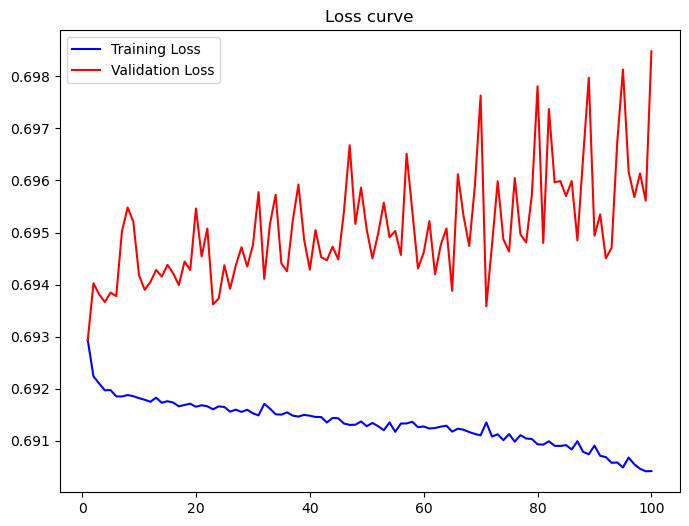

In [102]:
plt.figure(figsize=(8,6))
plt.title('Loss curve')
plt.plot(range(1,101), training_loss_values_lstm_classification, color='blue', label='Training Loss')
plt.plot(range(1,101), validation_loss_values_lstm_classification, color='red', label='Validation Loss')
plt.legend()
plt.show()

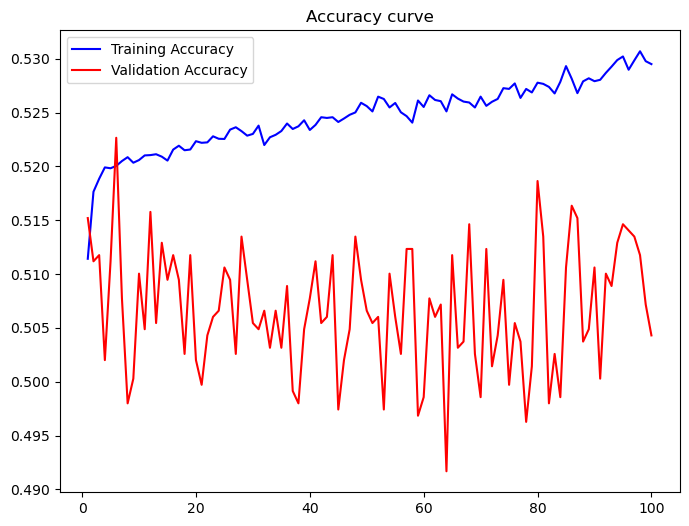

In [103]:
plt.figure(figsize=(8,6))
plt.title('Accuracy curve')
plt.plot(range(1,101), training_accuracy_values_lstm_classification, color='blue', label='Training Accuracy')
plt.plot(range(1,101), validation_accuracy_values_lstm_classification, color='red', label='Validation Accuracy')
plt.legend()
plt.show()

In [105]:
score=lstm_model_classification.evaluate(X_test, y_test)

55/55 [==============================] - 1s 8ms/step - loss: 0.6967 - accuracy: 0.4931


In [106]:
predicted_close_prices=lstm_model_classification.predict(X_test)

55/55 [==============================] - 1s 6ms/step


In [107]:
dataset_scaled[:, 5].shape

(351058,)

In [153]:
predicted_trend=(predicted_close_prices>=0.6).astype(int)
predicted_trend.shape

(1744, 1)

In [154]:
real_trend=np.reshape(dataset_scaled[-1744:, 5], newshape=(predicted_trend.shape[0], predicted_trend.shape[1]))

In [155]:
precision_score(real_trend, predicted_trend)

0.6666666666666666

### LSTM Regression Model

In [30]:
training_loss_values_lstm=np.loadtxt('./LSTM Model/TrainingLossValues.txt')
lstm_model=tf.keras.models.load_model('./LSTM Model/LSTM_model.h5')

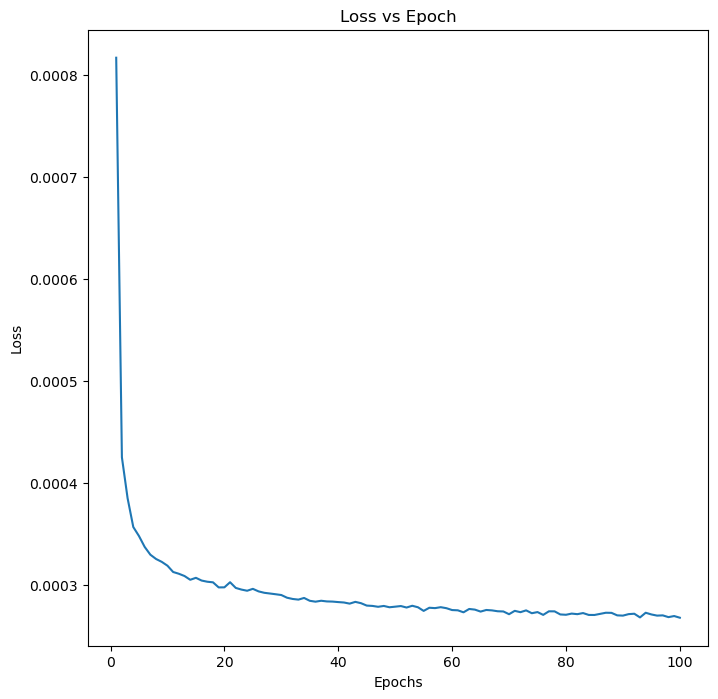

In [31]:
plt.figure(figsize=(8,8))
plt.title('Loss vs Epoch')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.plot(range(1, 101), training_loss_values_lstm)
plt.show()

In [32]:
test_inputs=test_and_validation_set[len(test_and_validation_set)-len(test_set):]
test_inputs.shape

(2745, 5)

In [33]:
X_test=[]
y_test=[]
for i in range(12, len(test_inputs)):
    X_test.append(test_inputs[i-12:i, :])
    y_test.append(test_inputs[i, 1])
    
X_test, y_test=np.array(X_test), np.array(y_test)
X_test=np.reshape(X_test, newshape=(X_test.shape[0], X_test.shape[1], X_test.shape[2]))
y_test.shape

(2733,)

In [34]:
score=lstm_model.evaluate(X_test, y_test)

86/86 [==============================] - 6s 13ms/step - loss: 1.3950e-06


In [35]:
predicted_close_prices=lstm_model.predict(X_test)

86/86 [==============================] - 3s 11ms/step


In [36]:
predicted_close_prices.shape

(2733, 1)

In [37]:
prediction_copies_array = np.repeat(predicted_close_prices,5, axis=-1)
predicted_close_prices = scaler.inverse_transform(np.reshape(prediction_copies_array,(len(predicted_close_prices),5)))[:,0]

In [38]:
y_test_copy = np.repeat(y_test,5, axis=-1)
y_test = scaler.inverse_transform(np.reshape(y_test_copy,(len(y_test),5)))[:,0]

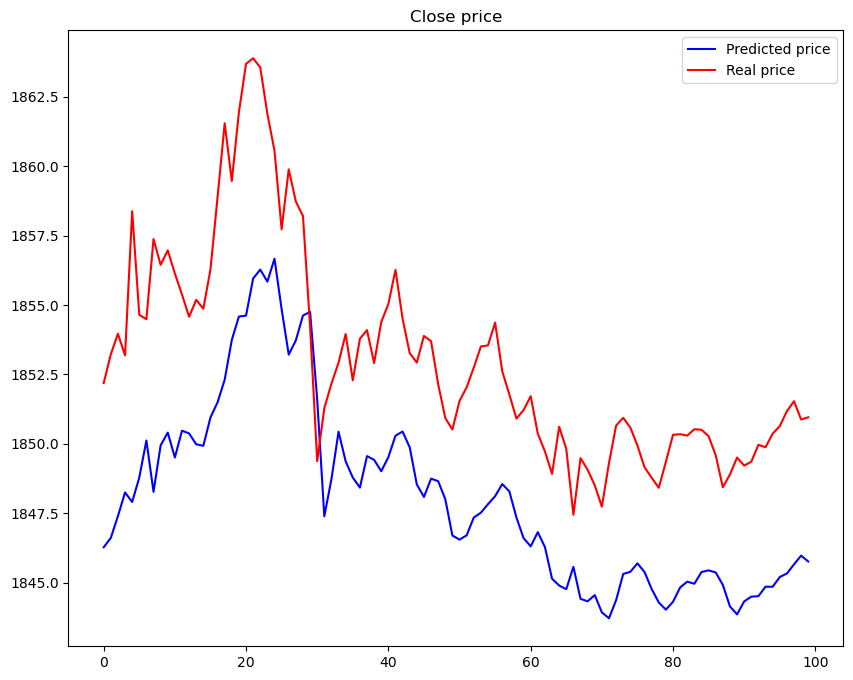

In [39]:
plt.figure(figsize=(10,8))
plt.plot(predicted_close_prices[len(predicted_close_prices)-100:len(predicted_close_prices)], color='blue', label='Predicted price')
plt.plot(y_test[len(y_test)-100:len(y_test)], color='red', label='Real price')
plt.title("Close price")
plt.legend()
plt.show()

### Building Random Forest Model

In [20]:
dataset_rf=df.copy()

In [21]:
dataset_rf['tomorrow']=dataset_rf['close'].shift(-1)

In [22]:
dataset_rf['target']=(dataset_rf['tomorrow'] > dataset_rf['close']).astype(int)

In [23]:
dataset_rf

,open,close,high,low,volume,target,tomorrow
time,,,,,,,
2020-04-09 00:00:00,172.20,172.12,172.34,172.07,204.24,0,171.93
2020-04-09 00:05:00,172.14,171.93,172.16,171.80,191.04,1,172.12
2020-04-09 00:10:00,171.94,172.12,172.26,171.91,200.84,0,172.02
2020-04-09 00:15:00,172.12,172.02,172.28,171.98,198.00,0,171.87
2020-04-09 00:20:00,171.99,171.87,172.10,171.72,208.17,1,171.88
...,...,...,...,...,...,...,...
2023-08-10 23:30:00,1849.37,1849.86,1849.86,1849.32,666.97,1,1850.13
2023-08-10 23:35:00,1849.86,1850.13,1850.13,1849.32,585.88,1,1850.67
2023-08-10 23:40:00,1850.14,1850.67,1850.71,1850.00,443.23,1,1851.03


In [24]:
randomForest_model=RandomForestClassifier(n_estimators=300, min_samples_split=100, random_state=1)

In [25]:
trainset_rf=dataset_rf.iloc[:-100]
testset_rf=dataset_rf.iloc[-100:]
predictors=['close', 'open', 'low', 'high', 'volume']

In [30]:
randomForest_model.fit(trainset_rf[predictors], trainset_rf['target'])

RandomForestClassifier(min_samples_split=100, n_estimators=150, random_state=1)

In [31]:
predictions=randomForest_model.predict(testset_rf[predictors])
predictions=pd.Series(predictions, index=testset_rf.index)

In [32]:
precision_score(testset_rf['target'], predictions)

0.47761194029850745

In [33]:
results_rf=pd.concat([testset_rf['target'], predictions], axis=1)

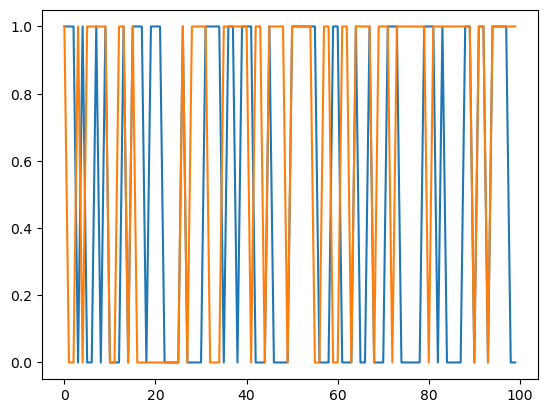

In [34]:
plt.plot(range(0,100) ,results_rf)
plt.show()

In [26]:
def predict(train, test, predictors, model):
    model.fit(train[predictors], train['target'])
    preds=model.predict_proba(test[predictors])[:,1]
    preds[preds>=0.6]=1
    preds[preds<0.6]=0
    preds=pd.Series(preds, index=test.index, name="Predictions")
    combined=pd.concat([test['target'], preds], axis=1)
    return combined

In [27]:
def backtest(data, model, predictors, start=2500, step=250):
    all_predictions=[]
    
    for i in range(start, data.shape[0], step):
        train=data.iloc[0:i].copy()
        test=data.iloc[i:(i+step)].copy()
        predictions=predict(train, test, predictors, model)
        all_predictions.append(predictions)
    return pd.concat(all_predictions)

In [28]:
horizons=[12, 60, 120, 216, 288]
new_predictors=[]

for horizon in horizons:
    rolling_averages=dataset_rf.rolling(horizon).mean()
    ratio_column=f"Close_Ratio_{horizon}"
    dataset_rf[ratio_column]=dataset_rf['close']/rolling_averages['close']
    
    trend_column=f"Trend_{horizon}"
    dataset_rf[trend_column]=dataset_rf.shift(1).rolling(horizon).sum()['target']
    
    new_predictors+=[ratio_column, trend_column]

In [29]:
dataset_rf=dataset_rf.dropna()

In [30]:
dataset_rf

,open,close,high,low,volume,target,tomorrow,Close_Ratio_12,Trend_12,Close_Ratio_60,Trend_60,Close_Ratio_120,Trend_120,Close_Ratio_216,Trend_216,Close_Ratio_288,Trend_288
time,,,,,,,,,,,,,,,,,
2020-04-10 00:00:00,169.03,168.94,169.04,168.86,190.78,1,169.06,0.999995,5.0,0.996742,27.0,0.994254,55.0,0.991846,106.0,0.989144,144.0
2020-04-10 00:05:00,168.94,169.06,169.16,168.94,212.42,1,169.64,1.000493,6.0,0.997531,27.0,0.995063,55.0,0.992593,107.0,0.989904,145.0
2020-04-10 00:10:00,169.03,169.64,169.68,169.00,183.46,1,169.69,1.003609,6.0,1.000937,28.0,0.998548,56.0,0.996041,107.0,0.993350,145.0
2020-04-10 00:15:00,169.66,169.69,169.69,169.43,199.67,1,170.48,1.003479,7.0,1.001224,28.0,0.998913,56.0,0.996384,107.0,0.993690,146.0
2020-04-10 00:20:00,169.68,170.48,170.48,169.57,190.82,0,170.29,1.007515,7.0,1.005791,29.0,1.003589,57.0,1.001046,108.0,0.998344,147.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-10 23:25:00,1849.46,1849.37,1849.99,1849.19,1153.56,1,1849.86,1.000093,5.0,0.999334,28.0,0.998338,55.0,0.998443,95.0,0.998178,136.0
2023-08-10 23:30:00,1849.37,1849.86,1849.86,1849.32,666.97,1,1850.13,1.000355,6.0,0.999631,28.0,0.998612,55.0,0.998719,96.0,0.998440,136.0
2023-08-10 23:35:00,1849.86,1850.13,1850.13,1849.32,585.88,1,1850.67,1.000496,6.0,0.999792,29.0,0.998763,56.0,0.998877,96.0,0.998586,136.0


In [31]:
dataset_rf.iloc[dataset_rf.shape[0]-105116:, :]

,open,close,high,low,volume,target,tomorrow,Close_Ratio_12,Trend_12,Close_Ratio_60,Trend_60,Close_Ratio_120,Trend_120,Close_Ratio_216,Trend_216,Close_Ratio_288,Trend_288
time,,,,,,,,,,,,,,,,,
2022-08-10 23:45:00,1821.68,1821.82,1823.53,1821.54,575.11,1,1822.49,1.000394,8.0,0.995997,26.0,1.011831,61.0,1.041860,111.0,1.049772,149.0
2022-08-10 23:50:00,1821.80,1822.49,1823.35,1820.80,358.46,0,1822.32,1.000782,8.0,0.996577,26.0,1.011609,61.0,1.041851,112.0,1.049885,149.0
2022-08-10 23:55:00,1822.51,1822.32,1823.30,1821.12,369.80,1,1827.52,1.000637,8.0,0.996675,26.0,1.010921,61.0,1.041346,112.0,1.049516,148.0
2022-08-11 00:00:00,1822.31,1827.52,1831.40,1822.31,2532.33,0,1826.02,1.003323,8.0,0.999673,26.0,1.013173,62.0,1.043877,113.0,1.052231,148.0
2022-08-11 00:05:00,1827.58,1826.02,1828.38,1824.56,4141.85,1,1830.88,1.002425,7.0,0.998981,26.0,1.011714,62.0,1.042593,112.0,1.051093,147.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-08-10 23:25:00,1849.46,1849.37,1849.99,1849.19,1153.56,1,1849.86,1.000093,5.0,0.999334,28.0,0.998338,55.0,0.998443,95.0,0.998178,136.0
2023-08-10 23:30:00,1849.37,1849.86,1849.86,1849.32,666.97,1,1850.13,1.000355,6.0,0.999631,28.0,0.998612,55.0,0.998719,96.0,0.998440,136.0
2023-08-10 23:35:00,1849.86,1850.13,1850.13,1849.32,585.88,1,1850.67,1.000496,6.0,0.999792,29.0,0.998763,56.0,0.998877,96.0,0.998586,136.0


In [33]:
predictions=backtest(dataset_rf.iloc[dataset_rf.shape[0]-105116:, :], randomForest_model, new_predictors)

In [45]:
predictions["Predictions"].value_counts()

0.0    98926
1.0     3690
Name: Predictions, dtype: int64

In [46]:
precision_score(predictions['target'], predictions['Predictions'])

0.5761517615176152

In [47]:
filepath='./Random Forest Model/Random_Forest_model.sav'
pickle.dump(randomForest_model, open(filepath, 'wb'))